In [2]:
import tensorflow.keras as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf
import matplotlib.pyplot as plt

Load Data

In [13]:
train_imgs = K.preprocessing.image_dataset_from_directory(
    'train',
    labels="inferred",
    label_mode="categorical",
    class_names=['cat', 'dog'],
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)

val_imgs = K.preprocessing.image_dataset_from_directory(
    'val',
    labels="inferred",
    label_mode="categorical",
    class_names=['cat', 'dog'],
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


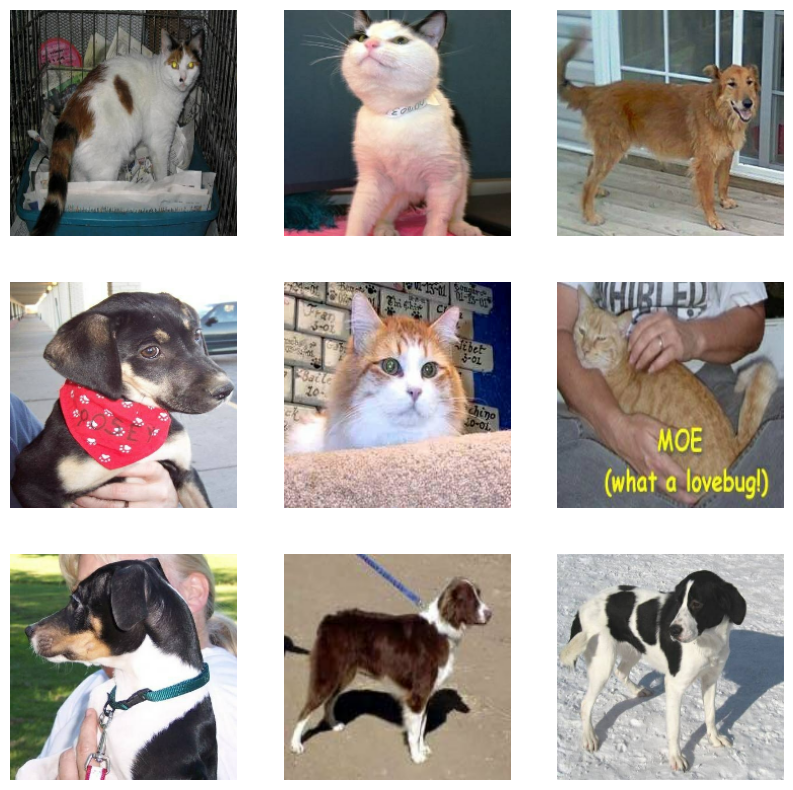

In [16]:
plt.figure(figsize=(10, 10))
for images, labels in train_imgs.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        #plt.title(int(labels[i]))
        plt.axis("off")

In [5]:
def normalize(image,label):
    image = tf.cast(image/255. ,tf.float32)
    label = tf.cast(label ,tf.float32)

    return image,label

def preprocess(image, label):
    flip = tf.keras.layers.RandomFlip("horizontal_and_vertical") # or "horizontal", "vertical"
    rotate = tf.keras.layers.RandomRotation(0.042)
    return rotate(flip(image)), label

train_imgs = train_imgs.map(normalize)
val_imgs = val_imgs.map(normalize)

Model

In [6]:
input_t = K.Input(shape=(224,224,3))
vgg16 = K.applications.VGG16(include_top=False, weights="imagenet", input_tensor=input_t)
vgg16.trainable = False

In [7]:
print("Number of layers in the base model: ", len(vgg16.layers))

Number of layers in the base model:  19


In [8]:
flatten_layer = K.layers.Flatten()
prediction_layer = K.layers.Dense(2, activation='sigmoid')

model = K.models.Sequential([
    vgg16,
    flatten_layer,
    prediction_layer
])

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    0.01,
    decay_steps=5,
    decay_rate=0.5,
    staircase=True
)

optimizer = K.optimizers.Adam(learning_rate=0.01)

model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy'],
)

In [9]:
from keras.callbacks import Callback

class l_rate(Callback):
    def on_epoch_end(self, epoch, logs=None):
        current_decayed_lr = self.model.optimizer._decayed_lr(tf.float32).numpy()
        print("current decayed lr: {:0.7f}".format(current_decayed_lr))

es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)
cp = ModelCheckpoint(filepath='./chkp/checkpoint.hdf5', save_weights_only=True, monitor='val_accuracy', mode='max', save_best_only=False)
l_r = l_rate()

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 2)                 50178     
                                                                 
Total params: 14,764,866
Trainable params: 50,178
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
history = model.fit(train_imgs, epochs=150, validation_data=val_imgs, batch_size=32, callbacks=[es, cp])

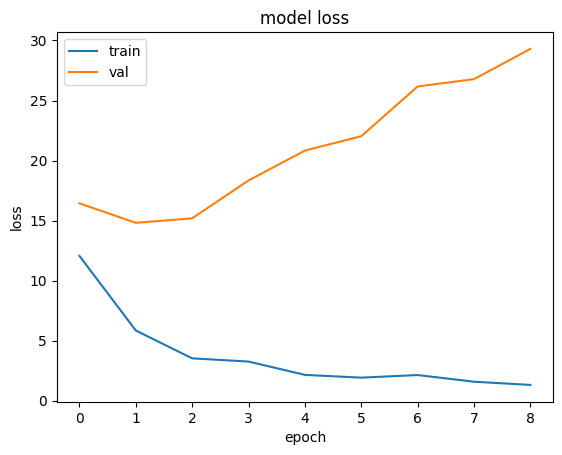

In [14]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

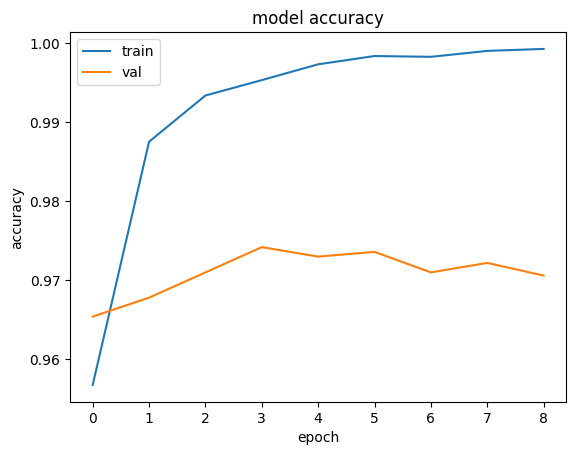

In [15]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()